In [2]:
from cgeniepy.ecology import EcoModel
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cgeniepy.array import GriddedData

arc_mask = xr.load_dataarray("../data/masked_array.nc")

def mask_arctic(input_data):
    "apply the new land-sea mask to the data"
    input_data = input_data * arc_mask
    return input_data

def pft_change(model):
    #carbon_thresholds = model.eco_pars()['q_C']

    ## recalculate because foram use a different method
    qcarbon_a = model.get_config('ECOGEM')['qcarbon_a']
    qcarbon_b = model.get_config('ECOGEM')['qcarbon_b']
    volume = model.eco_pars()['volume']
    carbon_thresholds = qcarbon_a * volume ** qcarbon_b

    ## counting from 0
    phyto_index = np.arange(0,32)
    zoo_index = np.arange(32,64)
    mixo_index = np.arange(64,96)
    foram_index = np.arange(96,112)

    ## diversity (no. of PFTs) map

    model_mask = model.grid_mask()

    phyto_rich, zoo_rich, mixo_rich, foram_rich = [], [], [], []

    for i in range(len(carbon_thresholds)):
        pft = model.get_pft(i+1)
        threshold = carbon_thresholds[i]    
        ## filter out the species with biomass less than threshold    
        pft_presence = xr.where(pft> threshold, 1, 0.0)
        if i in phyto_index:
            phyto_rich.append(pft_presence)
        elif i in zoo_index:
            zoo_rich.append(pft_presence)
        elif i in mixo_index:
            mixo_rich.append(pft_presence)
        elif i in foram_index:
            foram_rich.append(pft_presence)

    ## sum over PFT dimension
    phyto_rich = xr.concat(phyto_rich, dim='pft') * model_mask
    zoo_rich = xr.concat(zoo_rich, dim='pft') * model_mask
    mixo_rich = xr.concat(mixo_rich, dim='pft')* model_mask
    foram_rich = xr.concat(foram_rich, dim='pft')*model_mask
    total_pft = phyto_rich.sum(dim='pft') + zoo_rich.sum(dim='pft') +mixo_rich.sum(dim='pft') +foram_rich.sum(dim='pft')

    total_pft = mask_arctic(total_pft *model_mask)
    total_pft = GriddedData(total_pft, attrs={'long_name': 'Total PFTs',  'units': ''})
    return total_pft

main_model = EcoModel("../model/muffin.u067bc.PO4Fe.main", gemflag=['biogem', 'ecogem'])
solar_model = EcoModel("../model/muffin.u067bc.PO4Fe.solar", gemflag=['biogem', 'ecogem'])
co2_model = EcoModel("../model/muffin.u067bc.PO4Fe.CO2", gemflag=['biogem', 'ecogem'])
par_model = EcoModel("../model/muffin.u067bc.PO4Fe.forcePAR", gemflag=['biogem', 'ecogem'])
sst_model = EcoModel("../model/muffin.u067bc.PO4Fe.forceSST", gemflag=['biogem', 'ecogem'])

total_effect = pft_change(main_model)
solar_effect = pft_change(solar_model)
co2_effect = pft_change(co2_model)
par_effect = pft_change(par_model)
sst_effect = pft_change(sst_model)

Error registering colormaps: could not convert string to float: 'purple4'


In [3]:
a = 1 - total_effect[-1]/ total_effect[1]
b = 1 - solar_effect[-1]/ solar_effect[1]
c = 1 - co2_effect[-1]/ co2_effect[1]
d = 1 - par_effect[-1]/ par_effect[1]
e = 1 - sst_effect[-1]/ sst_effect[1]

In [4]:
a = GriddedData(a)
b = GriddedData(b)
c = GriddedData(c)
d = GriddedData(d)
e = GriddedData(e)

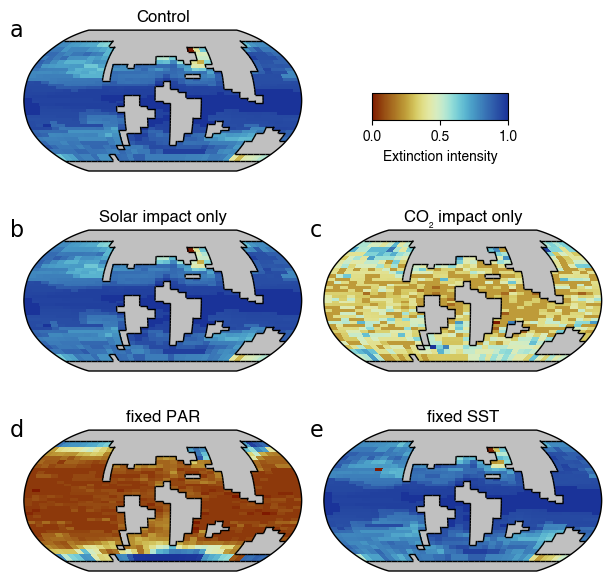

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from palettable.scientific.diverging import Roma_20

# continuous Matplotlib colormap
cmap = Roma_20.mpl_colormap

## set font type
plt.rcParams['font.family'] = 'Helvetica'

# your maps and labels
maps = [a, b, c, d, e]
letters = ['a', 'b', 'c', 'd', 'e']

# common norm and mappable
norm = Normalize(vmin=0.0, vmax=1.0)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# 3×2 PlateCarree grid
fig, axes = plt.subplots(
    3, 2,
    figsize=(6,6),
    subplot_kw={'projection': ccrs.Robinson()},
    constrained_layout=True
)
axes = axes.flatten()

# turn off the “empty” plot slot
axes[1].axis('off')

# carve out a smaller horizontal cax inside axes[1]
pos = axes[1].get_position()  # [x0, y0, width, height]
# shrink height to 20% of original and lift it 40% up
cax = fig.add_axes([pos.x0,
                    pos.y0 + pos.height*0.65,
                    pos.width,
                    pos.height*0.2])

# draw the horizontal colorbar
cbar = fig.colorbar(sm,
                    cax=cax,
                    orientation='horizontal',
                    label='Extinction intensity',
                    ticks=[0.0, 0.5, 1.0])

# plot each map in the remaining slots
for idx, data, letter in zip([0,2,3,4,5,1], maps, letters):
    ax = axes[idx]
    data_vis = data.to_GriddedDataVis()

    data_vis.aes_dict['facecolor_kwargs']['c'] = 'silver'

    data_vis.plot(
        ax=ax,
        cmap=cmap,
        norm=norm,
        colorbar=False,
        outline=True)
    ## add text
    ax.text(-0.05, 0.95, f'{letter}',
            transform=ax.transAxes,
            fontsize=16)
    

## add titles
titles = [
    'Control',
    '',
    'Solar impact only',
    'CO₂ impact only',
    'fixed PAR',
    'fixed SST',
]
for ax, title in zip(axes, titles):
    ax.set_title(title, fontsize=12, loc='center')

# save
plt.savefig("../output/fig3_all_panels_3x2_cartopy_cbar_horiz.png",
            dpi=300, bbox_inches='tight')